<a href="https://colab.research.google.com/github/Sina-Haz/Generative-Modelling/blob/main/score_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Seems like order matters when importing these libraries
# Should always import equinox first and then jax apparently

try:
  import equinox as eqx
except ModuleNotFoundError:
  !pip install -q equinox
  import equinox as eqx

import jax
import jax.numpy as np
from jax.scipy.stats import norm
from jax import grad, vmap
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 6.1 MB/s eta 0:00:00


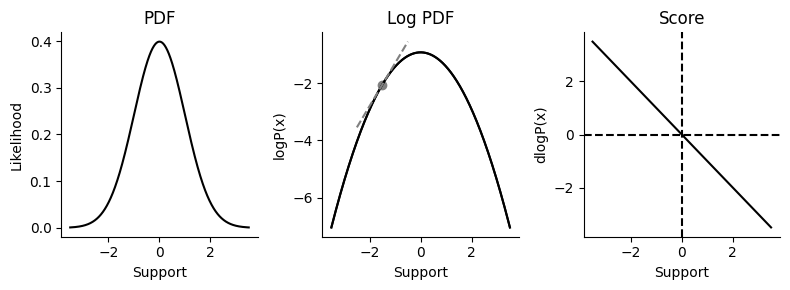

In [3]:
fig, axes = plt.subplots(figsize=(8, 3), nrows=1, ncols=3, sharex=True)

plt.sca(axes[0])
x = np.linspace(-3.5, 3.5, 1000)
y = norm.pdf(x)
plt.plot(x, y, color="black")
plt.xlabel("Support")
plt.ylabel("Likelihood")
plt.title("PDF")
sns.despine()

y = norm.logpdf(x)
plt.sca(axes[1])
plt.plot(x, y, color="black")
plt.xlabel("Support")
plt.ylabel("logP(x)")
plt.title("Log PDF")

# Tangent Line
def line(x):
    return grad(norm.logpdf)(x_pt) * (x - x_pt) + y_pt
x_pt = -1.5
y_pt = norm.logpdf(x_pt)
xrange = np.linspace(x_pt - 1, x_pt + 1, 10)
plt.plot(x, y, color="black")
plt.scatter(x_pt, y_pt, color="gray")
plt.plot(xrange, vmap(line)(xrange), color="gray", ls="--")


plt.sca(axes[2])
plt.plot(x, vmap(grad(norm.logpdf))(x), color="black")
plt.axhline(y=0, ls="--", color="black")
plt.axvline(x=0, ls="--", color="black")
plt.xlabel("Support")
plt.ylabel("dlogP(x)")
plt.title("Score")

sns.despine()
plt.tight_layout()

In [4]:
# Get gaussian score and assert that for normal standard its just -x
gaussian_score = grad(norm.logpdf)
gaussian_score(-4.), gaussian_score(0.), gaussian_score(4.)

(Array(4., dtype=float32, weak_type=True),
 Array(-0., dtype=float32, weak_type=True),
 Array(-4., dtype=float32, weak_type=True))

In [5]:
from jax import random

# Define our distribution as normal(mu = 3, sigma = 1)
key = random.PRNGKey(44)
true_mu, true_sigma = 2, 2.5
normal_data = random.normal(key, shape=(5000,1)) * true_sigma + true_mu

In [6]:
# Let's make a gaussian model
from jax import jacfwd

class GaussianScoreModel(eqx.Module):
  mu: np.array = np.array(0.0)
  log_sigma: np.array = np.array(0.0)

  @eqx.filter_jit
  def __call__(self, x):
    score = jacfwd(norm.logpdf)
    return score(x, loc=self.mu, scale=np.exp(self.log_sigma))


gauss_model = GaussianScoreModel()
gauss_model(-3.), gauss_model(0.), gauss_model(3.)

(Array(3., dtype=float32, weak_type=True),
 Array(-0., dtype=float32, weak_type=True),
 Array(-3., dtype=float32, weak_type=True))

In [7]:
# Lets make sure we can call this model over all of the data, squeeze this b/c resulting output is 3D tensor
data_score = vmap(gauss_model)(normal_data).squeeze()

data_score[0:3], normal_data.mean(), normal_data.std()

(Array([-4.9395485, -6.2203717, -6.1720495], dtype=float32),
 Array(1.9816449, dtype=float32),
 Array(2.5315151, dtype=float32))

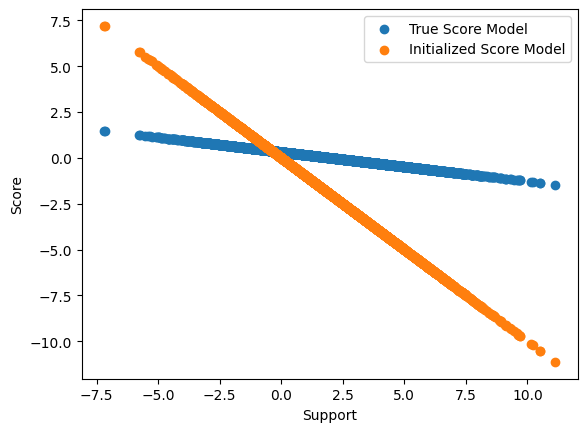

In [8]:
# Let's see what the actual scores vs. our untrained scores look like

true_model = GaussianScoreModel(mu=true_mu, log_sigma=np.log(true_sigma))
true_model_scores = vmap(true_model)(normal_data)
plt.scatter(normal_data.squeeze(), true_model_scores.squeeze(), label="True Score Model")
plt.scatter(normal_data.squeeze(), data_score.squeeze(), label="Initialized Score Model")
plt.xlabel("Support")
plt.ylabel("Score")
plt.legend();

In [9]:
# Implement score matching loss to train our gaussian model with gradient descent
from typing import Callable, List, Tuple
import optax
from tqdm.auto import tqdm

def score_matching_loss(model, data):
  '''
  data should have shape (batch, :), at least a 2D tensor
  '''
  # Compute the hessians of the logpdf (or jacobian of score fn)
  hess = vmap(jacfwd(model))(data)

  # Get the diagonals of the Hessians, correspond to derivative of score fn w.r.t. i-th data dimension
  # If it's a 2D tensor, add another dimension so that when we call np.diagonal it reduces dim instead of increasing it
  if hess.shape[-1] == 1 and len(hess.shape)==2:
    hess = np.expand_dims(hess, -1)
  term1 = vmap(np.diagonal)(hess)

  term2 = 0.5 * vmap(model)(data)**2
  term2 = np.reshape(term2, term1.shape) # reshape to be like term 1

  inner = term1 + term2
  # sum along data dimensions (mapping np.sum to each individual data tensor ensures final shape is (batch, ))
  inner = vmap(np.sum)(inner)

  # Now average over the entire batch of data
  loss = np.mean(inner)
  return loss

def fit(
    model: eqx.Module,
    data: np.array,
    loss_fn: Callable,
    optimizer: optax.GradientTransformation,
    steps: int,
    progress_bar: bool = True,
  ) -> Tuple[List[eqx.Module], List]:
  """
  Fit model to data

  data should have shape (batch, :), at least a 2D tensor

  returns updated model + loss training history
  """
  # Set up the state of the optimizer, filtering for weights which are inexact (which is apparently anything that is floating point)
  opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))

  # Here we call filter_value_and_grad s.t. it returns pair (value, grad). We jit compile it too to be faster
  dloss = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))

  @eqx.filter_jit
  def step(model, opt_state, data):
    """
    One step of training loop, jitted to run faster
    """

    loss, grads = dloss(model, data)

    # Next we compute the updates and obtain optimizer state
    updates, opt_state = optimizer.update(grads, opt_state)

    # Apply updates to the model
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

  loss_hist = []
  iterator = range(steps)
  if progress_bar: iterator = tqdm(iterator)

  for _ in iterator:
    model, opt_state, loss = step(model, opt_state, data)
    loss_hist.append(loss)
  return model, loss_hist

score_matching_loss(gauss_model, normal_data)

Array(4.1677423, dtype=float32)

In [10]:
# Now let's train the model
opt = optax.adam(learning_rate=5e-3)
updated_model, loss_hist = fit(gauss_model, normal_data, score_matching_loss, opt, 2000, progress_bar=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

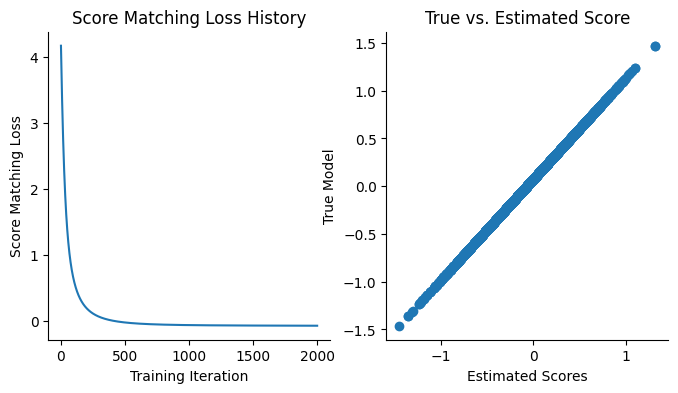

In [11]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)


plt.sca(axes[0])
plt.plot(loss_hist)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(normal_data)
plt.scatter(updated_model_scores.squeeze(), true_model_scores.squeeze())
plt.xlabel("Estimated Scores")
plt.ylabel("True Model")
plt.title("True vs. Estimated Score");

In [12]:
np.mean(normal_data), np.std(normal_data), updated_model.mu, np.exp(updated_model.log_sigma) # As we can see it matches up very well with data

(Array(1.9816449, dtype=float32),
 Array(2.5315151, dtype=float32),
 Array(1.5432378, dtype=float32),
 Array(2.5711524, dtype=float32))

In [13]:
# So clearly the loss function seems to work for our gaussian model, but what if now we assume we don't know the form of the logpdf
# and instead try to approximate score function via MLP?
from jax.tree_util import tree_flatten, tree_map

# Define mlp via equinox syntax
mlp = eqx.nn.MLP(
    in_size = 1,
    out_size = 1,
    width_size = 1024,
    depth=1,
    key=random.PRNGKey(45)
)

# Define regularized loss to penalize model for large weights
def regularized_loss(model, data):
  sm_loss = score_matching_loss(model, data)

  # compute l2 norm
  params = eqx.filter(model, eqx.is_array_like)
  squared = tree_map(lambda x: np.power(x, 2), params)
  summed = tree_map(np.sum, squared)
  flattened, _ = tree_flatten(summed)

  l2_norm = np.mean(np.array(flattened)) * 0.05 # scale it down too

  return sm_loss + l2_norm

In [14]:
optimizer = optax.chain(
    optax.clip(0.01),
    optax.sgd(learning_rate=5e-3),
)

updated_mlp, history = fit(
    mlp,
    normal_data,
    score_matching_loss,
    optimizer,
    steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

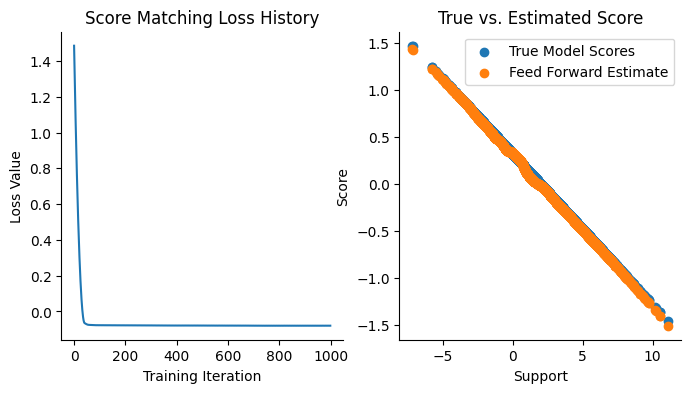

In [15]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(history)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_mlp)(normal_data).squeeze()
plt.scatter(normal_data.squeeze(), true_model_scores, label="True Model Scores")
plt.scatter(normal_data.squeeze(), updated_model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend();

### Final Comments on Modelling Gaussians

Seems we can learn 1D gaussians pretty well.
I want to note that when I experimented with gaussians with very large standard deviation I got nan results
 - this is likely because of numerical overflow in the loss function as the hessian of the estimated score function was too large for data that was very spread out
 - Possible fix: maybe scale down the magnitude of the weights when initializing my model? Look into numerical stability and clipping of the jacfwd function?

 Anyways, now let's ensure that our score model can learn the score of a gaussian mixture distribution which is much more nonlinear and complex


### Modelling Mixture Distributions
Now we will try to model more complex, multimodal distributions via score-matching.

To do this we will implement mixture gaussians which have the pdf: $$p(x) = \sum_{i=1}^K \pi_i N(x; \mu_i, \Sigma_i)$$

Where there are K gaussians each with their own parameters $\mu, \Sigma$ and $\pi$ is the weight assigned to each

In [47]:
from functools import partial


class MixtureGaussian(eqx.Module):
  pi: np.array
  mus: np.array
  logsigmas: np.array

  def __init__(self, mus, logsigmas, pi):
    self.mus = mus
    self.logsigmas = logsigmas
    self.pi = pi

    # Check that mus, log_sigmas, and ws are of the same length.
    lengths = set(map(len, [mus, logsigmas, pi]))
    if len(lengths) != 1:
        raise ValueError(
            "`mus`, `log_sigmas` and `ws` must all be of the same length!"
        )

  def pdf(self, x):
    return np.sum(self.pi * norm.pdf(x, loc=self.mus, scale=np.exp(self.logsigmas)))

  def lpdf(self, x):
    return np.log(self.pdf(x))

  # Fix this
  def logpdf(self, x):
    log_gaussians = vmap(partial(norm.logpdf, x)) (self.mus, np.exp(self.logsigmas))
    weighted_gaussians = log_gaussians * np.log(self.pi)
    log_pdf = np.logaddexp.reduce(weighted_gaussians)
    return log_pdf


  def sample(self, n_samples):
    # For each sample decide which gaussian to sample from based on weights
    props = np.round(n_samples * self.pi).astype(int)

    samples = [random.normal(key=key, shape=(prop, ), dtype=np.float32)*sigma + mu for prop,sigma,mu in zip(props,np.exp(self.logsigmas), self.mus)]
    samples = np.concatenate(samples)
    return samples

  @eqx.filter_jit
  def __call__(self, x):
    score = jacfwd(self.lpdf)
    return score(x)


False


Text(0.5, 1.0, 'Mixture Gaussian Score')

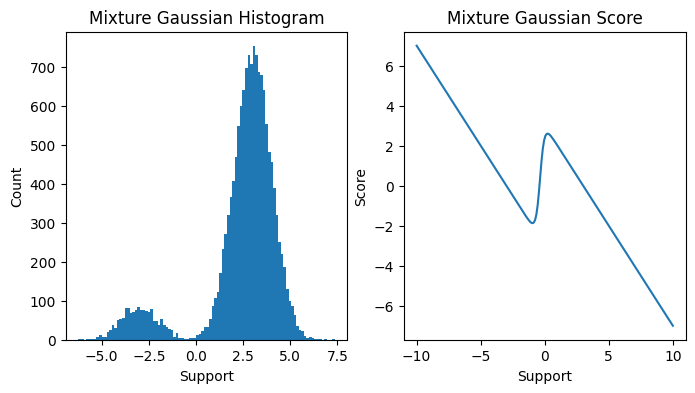

In [48]:

# Now we can plot distribution + it's score fn
x = np.linspace(-10, 10, 200)
mus = np.array([-3, 3])
sigmas = np.array([1, 1])
ws = np.array([0.1, 0.9])

mgmodel = MixtureGaussian(pi=ws, mus=mus, logsigmas=np.log(sigmas))

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
draws = 15000
mg2_data = mgmodel.sample(draws)
plt.hist(mg2_data, bins=100)
plt.title("Mixture Gaussian Histogram")
plt.xlabel("Support")
plt.ylabel("Count")

mg2_data = mg2_data.reshape(-1,1) # give it an extra dimension so we can feed it to our mlp model

print(np.allclose(vmap(mgmodel.logpdf)(x), vmap(mgmodel.lpdf)(x)))

plt.sca(axes[1])
plt.plot(x, vmap(mgmodel)(x))
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Mixture Gaussian Score")

In [18]:
# Now we will fit this with a NN model, I find that score_matching_loss w/o L2 regularization works better here
mlp_mgm = eqx.nn.MLP(
    in_size = 1,
    out_size = 1,
    width_size = 1024,
    depth=1,
    key=random.PRNGKey(45)
)

optimizer = optax.chain(
    optax.clip(0.01),
    optax.sgd(learning_rate=5e-3)
)

mgm_mlp, losses = fit(
    mlp_mgm,
    mg2_data,
    score_matching_loss,
    optimizer,
    steps=3_000
)

  0%|          | 0/3000 [00:00<?, ?it/s]

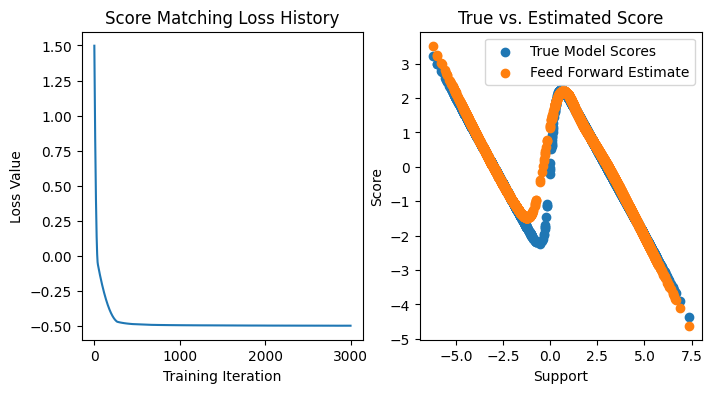

In [19]:
true_scores, model_scores = vmap(mgmodel)(mg2_data).squeeze(), vmap(mgm_mlp)(mg2_data).squeeze()


fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(losses)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")

plt.sca(axes[1])
plt.scatter(mg2_data.squeeze(), true_scores, label="True Model Scores")
plt.scatter(mg2_data.squeeze(), model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend();

Text(0.5, 1.0, 'Mixture Gaussian Score')

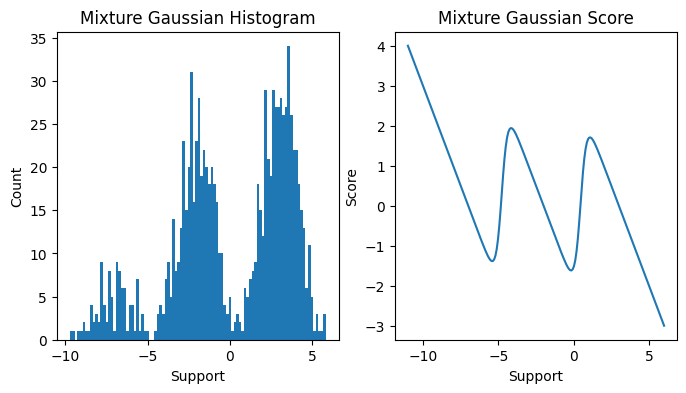

In [20]:
# Not bad at all! let's do the same for 3-comp mixture!!!
x = np.linspace(-11, 6, 200)
mus = np.array([-7, -2, 3])
sigmas = np.ones(3)
ws = np.array([0.1, 0.4, 0.5])

g3_model = MixtureGaussian(pi=ws, mus=mus, logsigmas=np.log(sigmas))
g3_data = g3_model.sample(1_000)

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.hist(g3_data, bins=100)
plt.title("Mixture Gaussian Histogram")
plt.xlabel("Support")
plt.ylabel("Count")

g3_data = g3_data.reshape(-1,1) # give it an extra dimension so we can feed it to our mlp model

plt.sca(axes[1])
plt.plot(x, vmap(g3_model)(x))
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Mixture Gaussian Score")

In [31]:
# sanity check this works with a defined mixture gaussian model
mg3_model = MixtureGaussian(pi=np.ones(3)/3, mus=np.array([-5.0, -1.0, 1.0]), logsigmas=np.log(np.ones(3) / 2)) # Make mus floats so that it's included in gradient computation

optimizer = optax.adam(learning_rate=1e-3)

updated, losses = fit(
    mg3_model,
    g3_data,
    score_matching_loss,
    optimizer,
    steps=2_000
)

  0%|          | 0/2000 [00:00<?, ?it/s]

[nan nan nan] [nan nan nan] [nan nan nan]


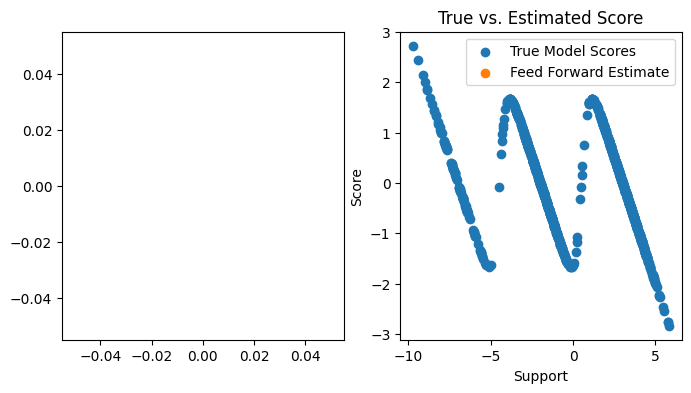

In [32]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

print(updated.mus, np.exp(updated.logsigmas), updated.pi)

plt.sca(axes[0])
plt.plot(losses)

plt.sca(axes[1])
plt.scatter(g3_data.squeeze(), vmap(g3_model)(g3_data).squeeze(), label="True Model Scores")
plt.scatter(g3_data.squeeze(), vmap(updated)(g3_data).squeeze(), label="Feed Forward Estimate");
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend();

In [27]:
mlp_g3 = eqx.nn.MLP(
    in_size = 1,
    out_size = 1,
    width_size = 1024,
    depth=2,
    key=random.PRNGKey(45),
    activation=jax.nn.relu
)

optimizer = optax.chain(
    optax.clip(0.001),
    optax.adabelief(learning_rate=1e-4)
)

g3_mlp, losses = fit(
    mlp_mgm,
    g3_data,
    regularized_loss,
    optimizer,
    steps=7_500
)

  0%|          | 0/7500 [00:00<?, ?it/s]

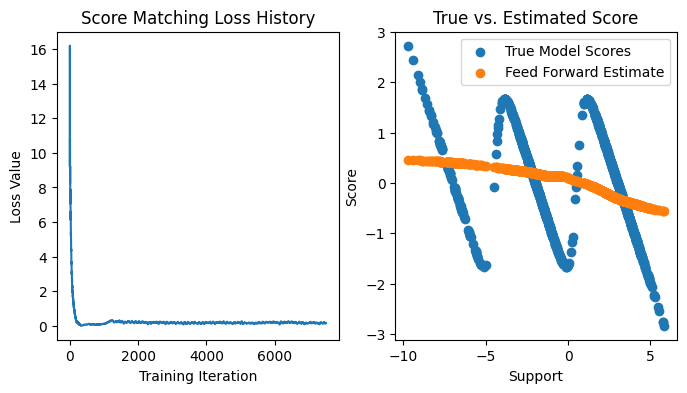

In [26]:
true_scores, model_scores = vmap(g3_model)(g3_data).squeeze(), vmap(g3_mlp)(g3_data).squeeze()


fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(losses)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")

plt.sca(axes[1])
plt.scatter(g3_data.squeeze(), true_scores, label="True Model Scores")
plt.scatter(g3_data.squeeze(), model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend();